# Create Target Feature

**Summary of the Article**
- Explication of the methodology.
- Import from csv.
- Crate the target feature for min_voltage_bus, max_voltage_bus, and max_current_line.
- Create Boolean Dataset.
- Crate Focused Dataset.
- Create Balanced Dataset.
- Save to csv.

## Methodology
The objective os this master thesis is to predict the occurance and amplitude of constraints violation in the results of the power flow. In order to train, test and evaluate the models it is usefull to transofrm the target output. Since the importante moments are those where the constraints are violated, it is usefull to create a new feature that expresses contains null values for when there is no constraint, and positive value for when there is a constraint. The positive values represent the amplitude of the constraint violation. It can be expressed as follows:
$$
    \begin{align}
        \text{Target} &= \begin{cases}
            0 & \text{if} \; \text{constraint} \; \text{is not violated} \\
            \text{amplitude of constraint} & \text{if} \; \text{constraint} \; \text{is violated} \\
        \end{cases}
    \end{align}
$$
In our case, the constraints are being considered as the following:
- Minimal voltage on bus: $v_bus < 0.95 \text{ [pu]}$ (constraint is violated if the voltage is below $0.95 \text{ [pu]} $)
- Maximal voltage on bus: $v_bus > 1.05 \text{ [pu]}$ (constraint is violated if the voltage is above $1.05 \text{ [pu]} $)
- Maximal current on line: $i_line > 1 \text{ [kA]}$ (constraint is violated if the current is above $1 \text{ [kA]} $)

## Import from csv
The results of the Power Flow are stored in a csv file. The csv files were created on the `pandapower_time_series_power_flow.ipynb` notebook.

Now we confirm that the target feature is created correctly, being in accord with the sparse dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
res_bus_vm_pu = pd.read_csv('..\data\ground_truth\pf_res_bus_vm_pu.csv')
res_line_i_ka = pd.read_csv('..\data\ground_truth\pf_res_line_i_ka.csv')
res_line_percent = pd.read_csv('..\data\ground_truth\pf_res_line_loading_percent.csv')
exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv')
timestamps = res_bus_vm_pu['timestamps'].apply(lambda x: pd.to_datetime(x))
res_bus_vm_pu.drop('timestamps', axis=1, inplace=True) 
res_line_i_ka.drop('timestamps', axis=1, inplace=True)
res_line_percent.drop('timestamps', axis=1, inplace=True)

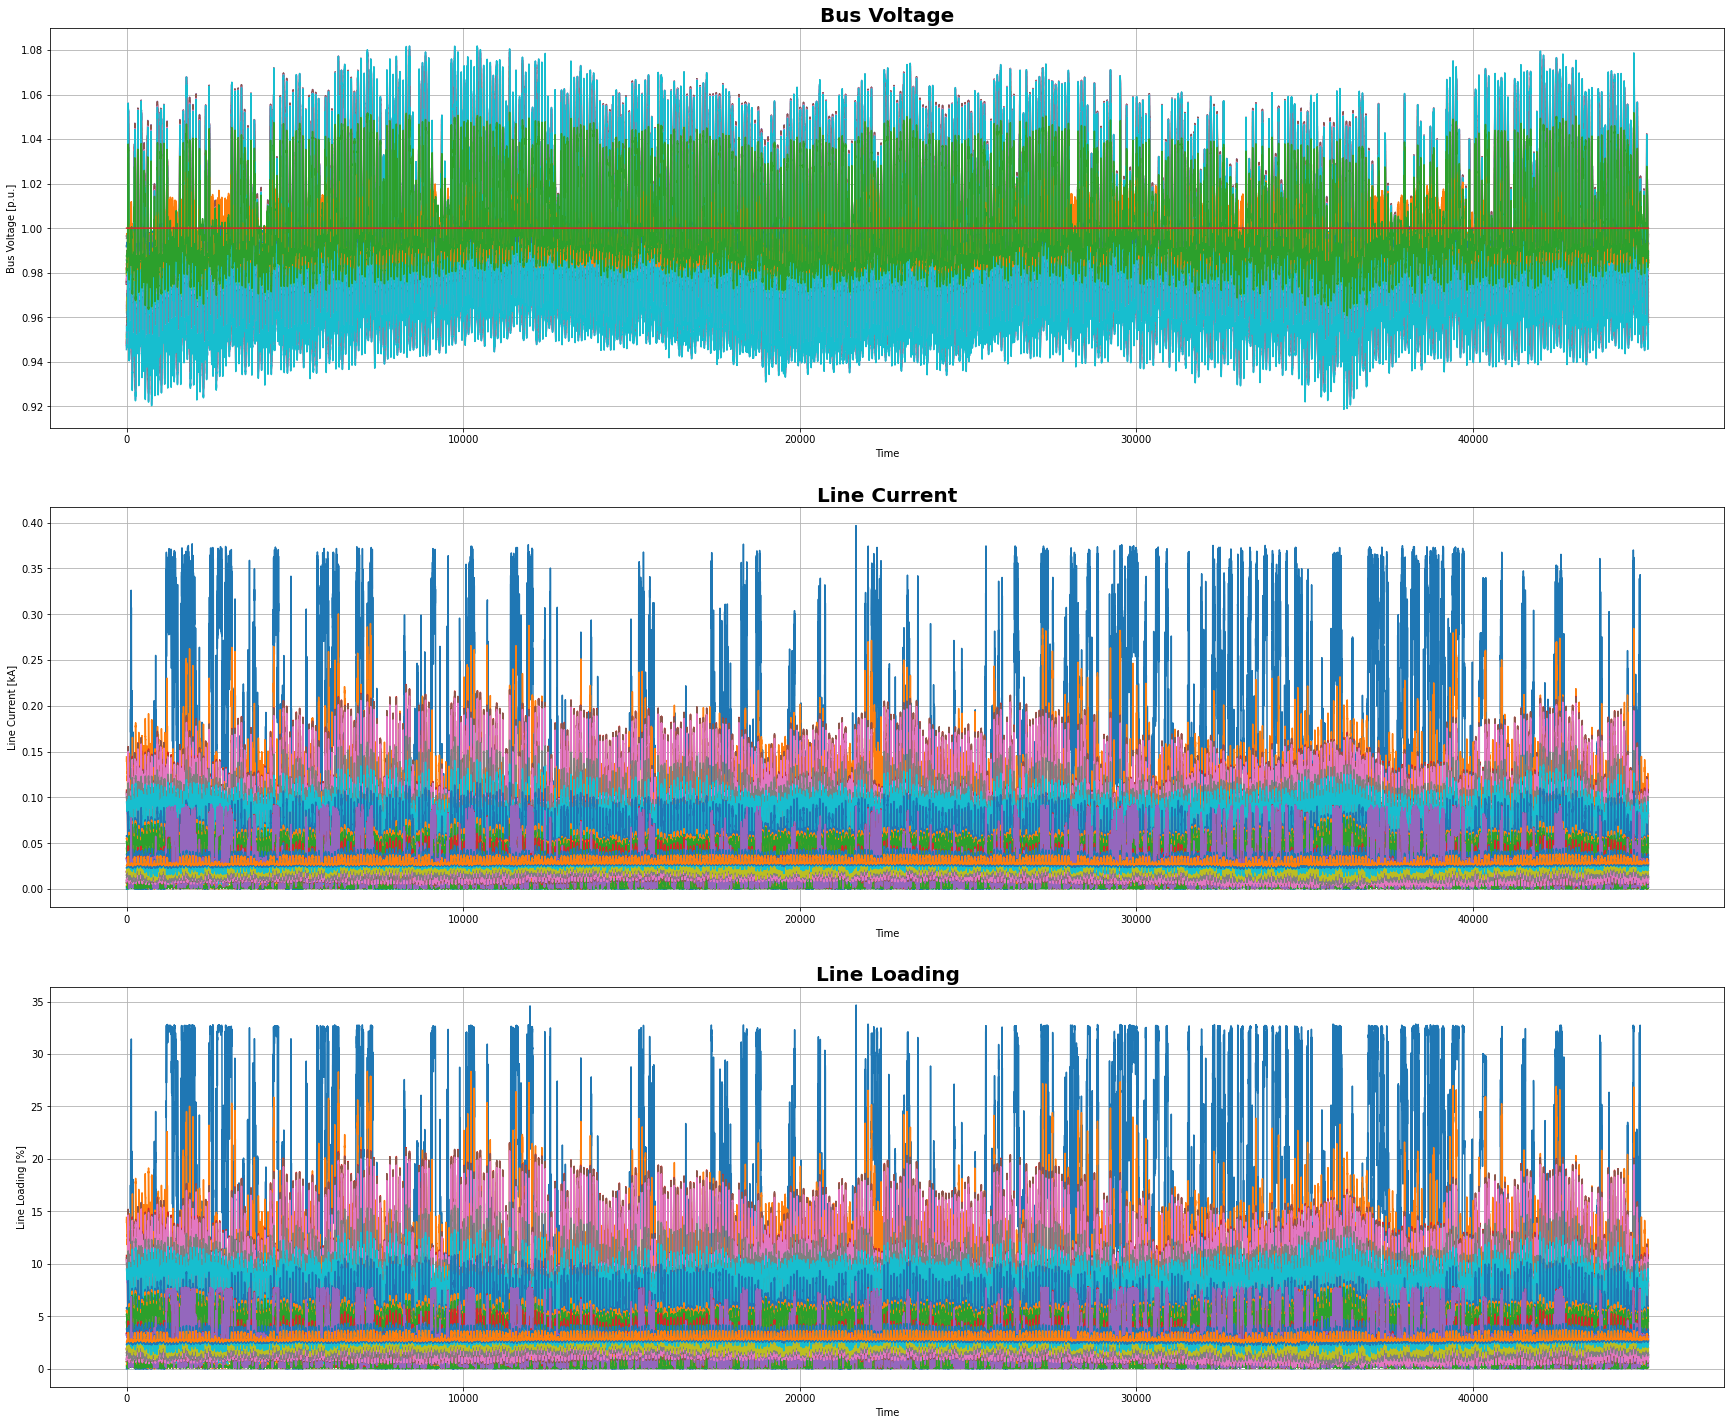

In [2]:
fig, axs = plt.subplots(3, 1, figsize=(30, 25))
# set the x-axis label
axs[0].set_xlabel('Time')
axs[1].set_xlabel('Time')
axs[2].set_xlabel('Time')
# set the y-axis label
axs[0].set_ylabel('Bus Voltage [p.u.]')
axs[1].set_ylabel('Line Current [kA]')
axs[2].set_ylabel('Line Loading [%]')
# set the title, bold and fontsize of the title
axs[0].set_title('Bus Voltage', fontsize=20, fontweight='bold')
axs[1].set_title('Line Current', fontsize=20, fontweight='bold')
axs[2].set_title('Line Loading', fontsize=20, fontweight='bold')
# Set grid
axs[0].grid(True)
axs[1].grid(True)
axs[2].grid(True)
# Data
axs[0].plot(res_bus_vm_pu)
axs[1].plot(res_line_i_ka)
axs[2].plot(res_line_percent)
# Don't print nothing on console
plt.show()


## Create Sparse Datset
In this section the target features are created using the formula above and stored in a new csv file.

In [3]:
# Min bus_vm_pu constraint
res_bus_vm_pu_min_constr = res_bus_vm_pu.apply(lambda x: (0.95 - x).apply(lambda y: max(0, y)))
# Max bus_vm_pu constraint
res_bus_vm_pu_max_constr = res_bus_vm_pu.apply(lambda x: (x - 1.05).apply(lambda y: max(0, y)))
# Current i_ka constraint.
res_line_i_ka_max_constr = res_line_i_ka.apply(lambda x: (x - 1 ).apply(lambda y: max(0, y)))
# Line loading percent constraint
res_line_percent_constr = res_line_percent.apply(lambda x: (x-100).apply(lambda y: max(0, y)))

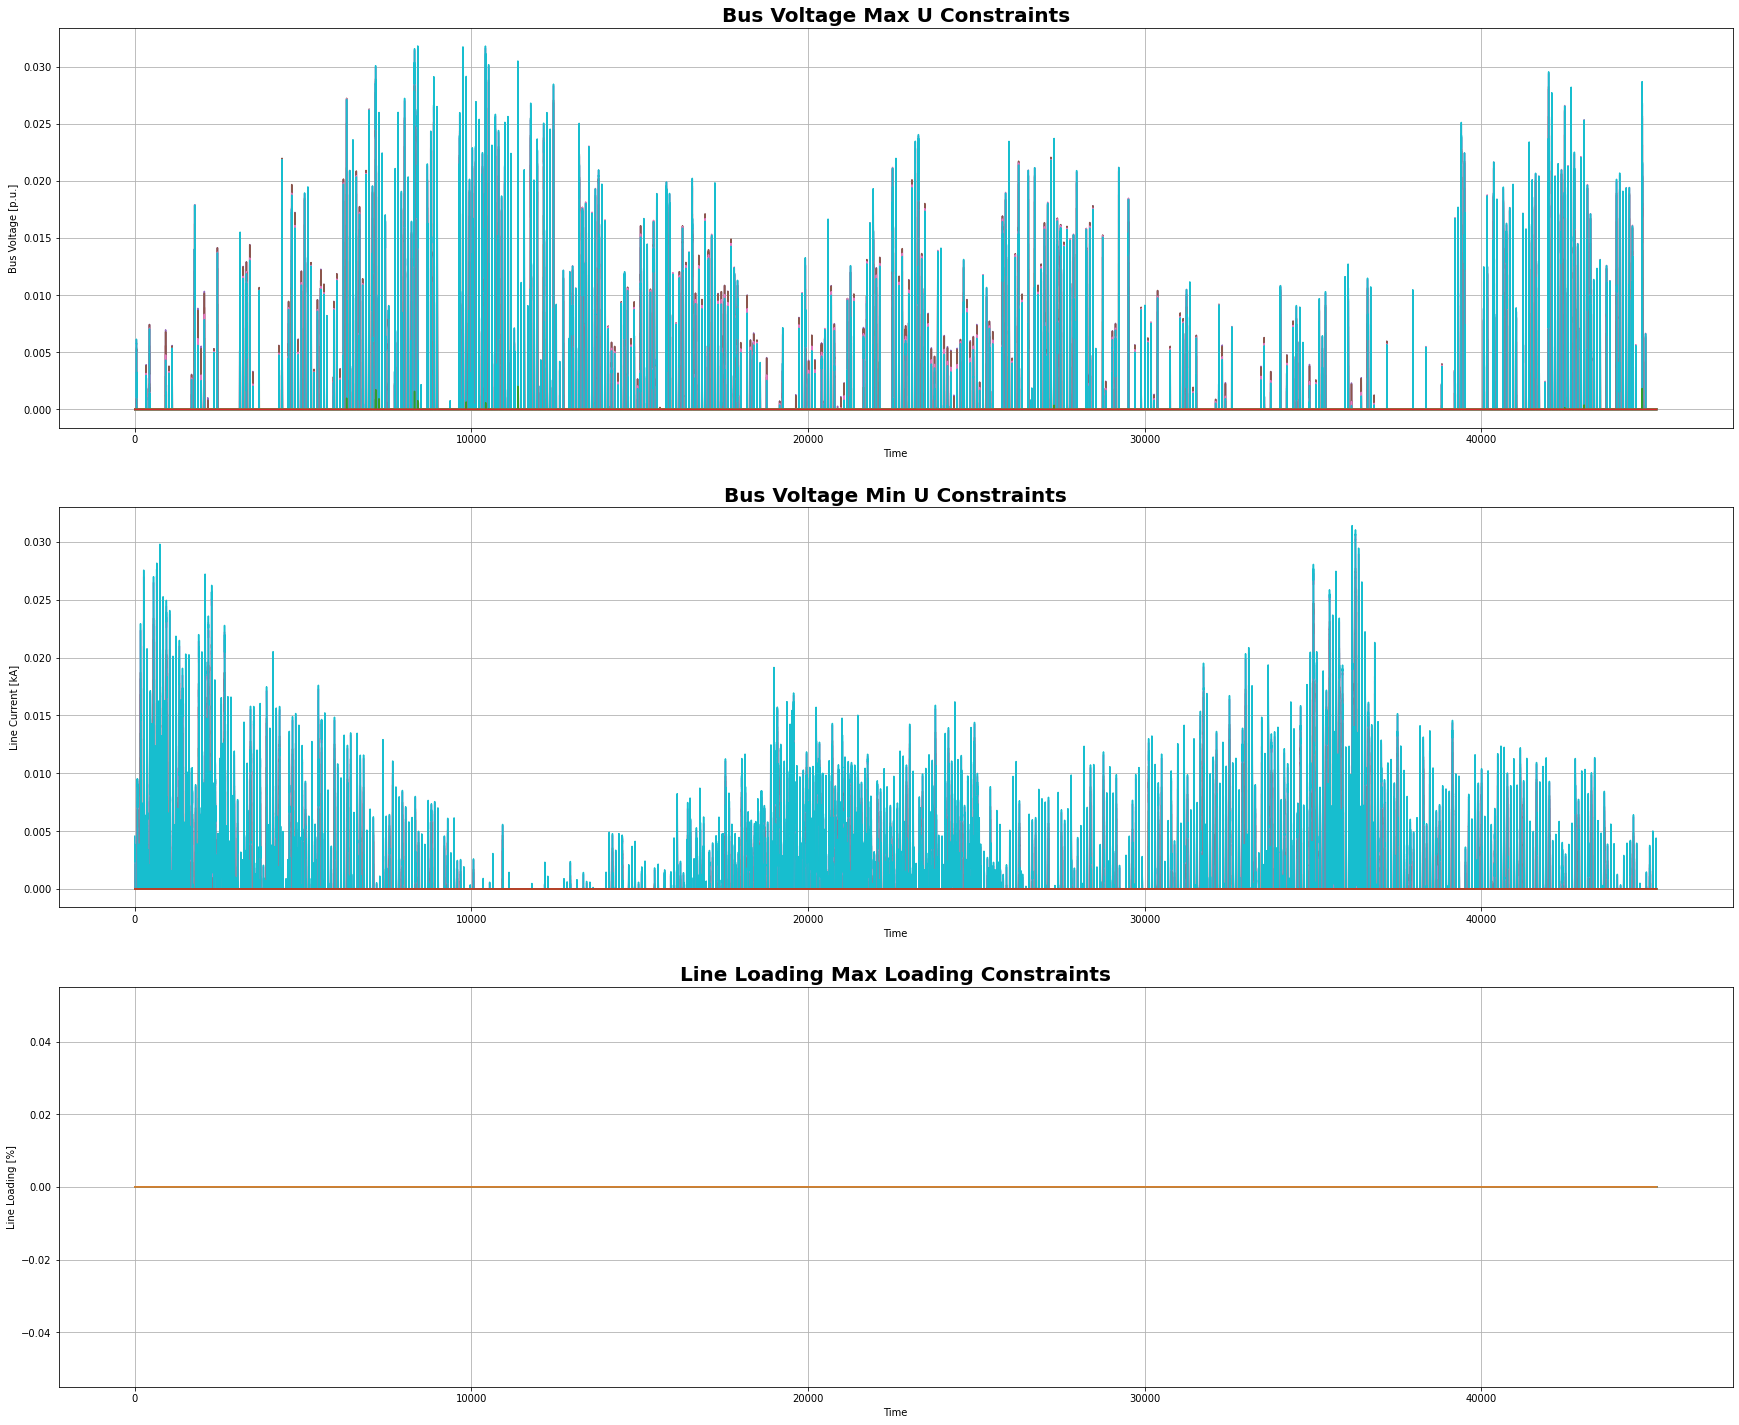

In [4]:
# Plot the three constraints like the plots done above
fig, axs = plt.subplots(3, 1, figsize=(30, 25))
# set the x-axis label
axs[0].set_xlabel('Time')
axs[1].set_xlabel('Time')
axs[2].set_xlabel('Time')
# set the y-axis label
axs[0].set_ylabel('Bus Voltage [p.u.]')
axs[1].set_ylabel('Line Current [kA]')
axs[2].set_ylabel('Line Loading [%]')
# set the title, bold and fontsize of the title
axs[0].set_title('Bus Voltage Max U Constraints', fontsize=20, fontweight='bold')
axs[1].set_title('Bus Voltage Min U Constraints', fontsize=20, fontweight='bold')
axs[2].set_title('Line Loading Max Loading Constraints', fontsize=20, fontweight='bold')
# Set grid
axs[0].grid(True)
axs[1].grid(True)
axs[2].grid(True)
# Data
axs[0].plot(res_bus_vm_pu_max_constr)
axs[1].plot(res_bus_vm_pu_min_constr)
axs[2].plot(res_line_percent_constr)
# Don't print nothing on console
plt.show()

Some visualisations are created to help the user understand the target feature.

In [5]:
import sys; sys.path.append('..');from thesis_package import utils
import numpy as np

In [6]:
utils.compute_threshold(res_bus_vm_pu_max_constr)

0.0016733255333549798

## Create Boolean Dataset
The target feature is created using the formula above. The target feature is then converted to a boolean dataset. The boolean dataset will further be used for binary classification tasks.

In [7]:
# Take a df and turn turn a cell to 1 when it is grater than 0, otherwise 0.
def turn_boolean(df, threshold):
    df = df.apply(lambda x: x.apply(lambda y: 1 if y > threshold else 0))
    return df
res_bus_vm_pu_max_sparse_bool_constr = turn_boolean(res_bus_vm_pu_max_constr, utils.compute_threshold(res_bus_vm_pu_max_constr))
res_bus_vm_pu_min_sparse_bool_constr = turn_boolean(res_bus_vm_pu_min_constr, utils.compute_threshold(res_bus_vm_pu_min_constr))
res_line_i_ka_max_sparse_bool_constr = turn_boolean(res_line_i_ka_max_constr, utils.compute_threshold(res_line_i_ka_max_constr))
res_line_percent_sparse_bool_constr = turn_boolean(res_line_percent_constr, utils.compute_threshold(res_line_percent_constr))

print('Turned res_bus_vm_pu_max_sparse_bool_constr into boolean data set with threshold ', utils.compute_threshold(res_bus_vm_pu_max_constr))
print('Turned res_bus_vm_pu_min_sparse_bool_constr into boolean data set with threshold ', utils.compute_threshold(res_bus_vm_pu_min_constr))
print('Turned res_line_i_ka_max_sparse_bool_constr into boolean data set with threshold ', utils.compute_threshold(res_line_i_ka_max_constr))
print('Turned res_line_percent_sparse_bool_constr into boolean data set with threshold ', utils.compute_threshold(res_line_percent_constr))

Turned res_bus_vm_pu_max_sparse_bool_constr into boolean data set with threshold  0.0016733255333549798
Turned res_bus_vm_pu_min_sparse_bool_constr into boolean data set with threshold  0.0020221186215737463
Turned res_line_i_ka_max_sparse_bool_constr into boolean data set with threshold  0.0025
Turned res_line_percent_sparse_bool_constr into boolean data set with threshold  0.0025


check results

In [8]:
print(res_bus_vm_pu_max_constr[res_bus_vm_pu_max_constr > utils.compute_threshold(res_bus_vm_pu_max_constr)].count().sum())
print(res_bus_vm_pu_max_sparse_bool_constr.sum().sum())
print('Threshold: ', utils.compute_threshold(res_bus_vm_pu_max_constr))

22162
22162
Threshold:  0.0016733255333549798


In [9]:
print(res_bus_vm_pu_min_constr[res_bus_vm_pu_min_constr > utils.compute_threshold(res_bus_vm_pu_min_constr)].count().sum())
res_bus_vm_pu_min_sparse_bool_constr.sum().sum()

35489


35489

In [10]:
print(res_bus_vm_pu_max_constr[res_bus_vm_pu_max_constr < utils.compute_threshold(res_bus_vm_pu_max_constr)].count().sum())
print(res_bus_vm_pu_max_sparse_bool_constr.shape[0]*res_bus_vm_pu_max_sparse_bool_constr.shape[1] - res_bus_vm_pu_max_sparse_bool_constr.sum().sum())
print(utils.compute_threshold(res_bus_vm_pu_max_constr))

1515182
1515182
0.0016733255333549798


In [11]:
print(res_bus_vm_pu_min_constr[res_bus_vm_pu_min_constr < utils.compute_threshold(res_bus_vm_pu_min_constr)].count().sum())
print(res_bus_vm_pu_min_sparse_bool_constr.shape[0]*res_bus_vm_pu_min_sparse_bool_constr.shape[1] - res_bus_vm_pu_min_sparse_bool_constr.sum().sum())
utils.compute_threshold(res_bus_vm_pu_min_constr)

1501855
1501855


0.0020221186215737463

Same number of positives.

## Check Filtered Dataset

In [12]:
from copy import deepcopy
# Classification data
y_max_u_bool = deepcopy(res_bus_vm_pu_max_sparse_bool_constr)
y_min_u_bool = deepcopy(res_bus_vm_pu_min_sparse_bool_constr)
y_max_u_bool = y_max_u_bool[utils.cols_with_positive_values(y_max_u_bool)]
y_min_u_bool = y_min_u_bool[utils.cols_with_positive_values(y_min_u_bool)]
_exogenous_data = deepcopy(exogenous_data.drop(columns=['date']))
train_x, test_x, train_y, test_y, scaler = utils.split_and_suffle(_exogenous_data, y_max_u_bool, test_size=0.2, scaling=True)
data_max_u_bool = {'X_train': deepcopy(train_x), 'X_test': deepcopy(test_x), 'y_train': deepcopy(train_y), 'y_test': deepcopy(test_y), 'scaler': deepcopy(scaler)}
train_x, test_x, train_y, test_y, scaler = utils.split_and_suffle(_exogenous_data, y_min_u_bool, test_size=0.2, scaling=True)
data_min_u_bool = {'X_train': deepcopy(train_x), 'X_test': deepcopy(test_x), 'y_train': deepcopy(train_y), 'y_test': deepcopy(test_y), 'scaler': deepcopy(scaler)}
# Filtered data
y_max_u_sparse = deepcopy(res_bus_vm_pu_max_constr)
y_min_u_sparse = deepcopy(res_bus_vm_pu_min_constr)
y_max_u_filtered = y_max_u_sparse[utils.cols_with_positive_values(y_max_u_bool)]
y_min_u_filtered = y_min_u_sparse[utils.cols_with_positive_values(y_min_u_bool)]

train_x, test_x, train_y, test_y, scaler = utils.split_and_suffle(_exogenous_data, y_max_u_filtered, test_size=0.2, scaling=True)
data_max_u_filtered = {'X_train': deepcopy(train_x), 'X_test': deepcopy(test_x), 'y_train': deepcopy(train_y), 'y_test': deepcopy(test_y), 'scaler': deepcopy(scaler)}

train_x, test_x, train_y, test_y, scaler = utils.split_and_suffle(_exogenous_data, y_min_u_filtered, test_size=0.2, scaling=True)
data_min_u_filtered = {'X_train': deepcopy(train_x), 'X_test': deepcopy(test_x), 'y_train': deepcopy(train_y), 'y_test': deepcopy(test_y), 'scaler': deepcopy(scaler)}

In [25]:
# Print the size of the classiciation testing data and the filtered testing data
print('Classification data size: ', data_max_u_bool['y_test'].shape)
print('Regression data size: ', data_max_u_filtered['y_test'].shape)
print('Positive in classification data: ', utils.count_positives_class(data_max_u_bool['y_test']))
unscaled_y_test = data_max_u_filtered['scaler']['y'] * data_max_u_filtered['y_test']
print('Positive in regression data: ', utils.count_positives_reg(unscaled_y_test, utils.compute_threshold(y_max_u_sparse)))
print('Negative in regression data: ', utils.count_negatives_reg(unscaled_y_test, utils.compute_threshold(y_max_u_sparse)))
print('Negative in regression data: ', utils.count_negatives_reg(unscaled_y_test, utils.compute_threshold(y_max_u_sparse)))

Classification data size:  (9044, 11)
Regression data size:  (9044, 11)
Positive in classification data:  4949.0
Positive in regression data:  4949
Negative in regression data:  94535
Negative in regression data:  94535


## Create Focused Dataset
The focused dataset consists only of the rows in which at least one target feature is non-zerio, that is, there is at least on constraint violation.

In [17]:
def get_focused_df(df, bool_df):
    indexes = [] 
    for row in bool_df.iterrows():
        if not row[1].any():
            indexes.append(row[0])
    return df.drop(indexes)
res_bus_vm_pu_min_focused_constr = get_focused_df(res_bus_vm_pu_min_constr, res_bus_vm_pu_min_sparse_bool_constr)
exogenous_data_vm_pu_min_focused = get_focused_df(exogenous_data, res_bus_vm_pu_min_sparse_bool_constr)
res_bus_vm_pu_max_focused_constr = get_focused_df(res_bus_vm_pu_max_constr, res_bus_vm_pu_max_sparse_bool_constr)
exogenous_data_vm_pu_max_focused = get_focused_df(exogenous_data, res_bus_vm_pu_max_sparse_bool_constr)
res_line_i_ka_max_focused_constr = get_focused_df(res_line_i_ka_max_constr, res_line_i_ka_max_sparse_bool_constr)
exogenous_data_i_ka_max_focused = get_focused_df(exogenous_data, res_line_i_ka_max_sparse_bool_constr)
res_line_percent_focused_constr = get_focused_df(res_line_percent_constr, res_line_percent_sparse_bool_constr)
exogenous_data_percent_focused = get_focused_df(exogenous_data, res_line_percent_sparse_bool_constr)

It is to notice that the balanced dataset is not the same as the original dataset.
**TODO PLOT difference between size of datasets**

## Create Balanced Dataset 
The balanced datset consists on o dataset that constains an equal number of rows that have constraints violations and that do not have constraints violations. The data set is shuffled.

In [18]:
def get_balanced_df(df, bool_df, focused_df): 
    # Returns a df with all the rows that are fully 0.
    indexes = [] 
    for row in bool_df.iterrows():
        if row[1].any():
            indexes.append(row[0])
    zero_df = df.drop(indexes)
    balanced_df = focused_df
    # Get random rows of the zero_df, append them to the focused_df and shuffle the result.
    balanced_df = balanced_df.append(zero_df.sample(n=balanced_df.shape[0], random_state=42))
    balanced_df = balanced_df.sample(frac=1, random_state=42)
    return balanced_df
res_bus_vm_pu_min_balanced_constr = get_balanced_df(res_bus_vm_pu_min_constr, res_bus_vm_pu_min_sparse_bool_constr, res_bus_vm_pu_min_focused_constr)
exogenous_data_vm_pu_min_balanced = get_balanced_df(exogenous_data, res_bus_vm_pu_min_sparse_bool_constr, exogenous_data_vm_pu_min_focused)
res_bus_vm_pu_max_balanced_constr = get_balanced_df(res_bus_vm_pu_max_constr, res_bus_vm_pu_max_sparse_bool_constr, res_bus_vm_pu_max_focused_constr)
exogenous_data_vm_pu_max_balanced = get_balanced_df(exogenous_data, res_bus_vm_pu_max_sparse_bool_constr, exogenous_data_vm_pu_max_focused)
res_line_i_ka_max_balanced_constr = get_balanced_df(res_line_i_ka_max_constr, res_line_i_ka_max_sparse_bool_constr, res_line_i_ka_max_focused_constr)
exogenous_data_i_ka_max_balanced = get_balanced_df(exogenous_data, res_line_i_ka_max_sparse_bool_constr, exogenous_data_i_ka_max_focused)
res_line_percent_balanced_constr = get_balanced_df(res_line_percent_constr, res_line_percent_sparse_bool_constr, res_line_percent_focused_constr)
exogenous_data_percent_balanced = get_balanced_df(exogenous_data, res_line_percent_sparse_bool_constr, exogenous_data_percent_focused)

C:\Users\jamil\AppData\Local\Temp\ipykernel_17980\3363540180.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = balanced_df.append(zero_df.sample(n=balanced_df.shape[0], random_state=42))
C:\Users\jamil\AppData\Local\Temp\ipykernel_17980\3363540180.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = balanced_df.append(zero_df.sample(n=balanced_df.shape[0], random_state=42))
C:\Users\jamil\AppData\Local\Temp\ipykernel_17980\3363540180.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = balanced_df.append(zero_df.sample(n=balanced_df.shape[0], random_state=42))
C:\Users\jamil\AppData\Local\Temp\ipykernel_17980\3363540180.py:10: FutureWarning: The frame.append method is deprecated 

In [19]:
def sanity_check(balanced_df, threshold):
    ctr = 0
    for row in balanced_df.iterrows():
        _row = row[1] > threshold
        if _row.any():
            ctr += 1
    print('{} / 2 = {} == {}'.format(balanced_df.shape[0], ctr, balanced_df.shape[0]/2))
    print('threshold = {}'.format(threshold))
threshold = utils.compute_threshold(res_bus_vm_pu_max_constr)
sanity_check(res_bus_vm_pu_max_balanced_constr, threshold)
threshold = utils.compute_threshold(res_bus_vm_pu_min_constr)
sanity_check(res_bus_vm_pu_min_balanced_constr, threshold)

6952 / 2 = 3476 == 3476.0
threshold = 0.0016733255333549798
13956 / 2 = 6978 == 6978.0
threshold = 0.0020221186215737463


## Create Balanced Boolean Dataset
From the dataset above we can create a balanced boolean dataset to train and test binary classification models. 

In [20]:
res_bus_vm_pu_min_balanced_bool_constr = turn_boolean(res_bus_vm_pu_min_balanced_constr, utils.compute_threshold(res_bus_vm_pu_min_balanced_constr))
res_bus_vm_pu_max_balanced_bool_constr = turn_boolean(res_bus_vm_pu_max_balanced_constr, utils.compute_threshold(res_bus_vm_pu_max_balanced_constr))

## Save to csv
The target features are saved to a csv file.

In [21]:
# Create timestaps feature to the dataframe and save it to csv.
# min_vm_pu
res_bus_vm_pu_min_constr['timestamps'] = timestamps
res_bus_vm_pu_min_constr.to_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv', index=False)
res_bus_vm_pu_min_sparse_bool_constr['timestamps'] = timestamps
res_bus_vm_pu_min_sparse_bool_constr.to_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv', index=False)
res_bus_vm_pu_min_focused_constr.to_csv('..\data\ground_truth\\res_bus_vm_pu_min_focused_constr.csv', index=False)
res_bus_vm_pu_min_balanced_constr.to_csv('..\data\ground_truth\\res_bus_vm_pu_min_balanced_constr.csv', index=False)
res_bus_vm_pu_min_balanced_bool_constr.to_csv('..\data\ground_truth\\res_bus_vm_pu_min_balanced_bool_constr.csv', index=False)
exogenous_data_vm_pu_min_focused.to_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_focused.csv', index=False)
exogenous_data_vm_pu_min_balanced.to_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_balanced.csv', index=False)

In [22]:
# max_vm_pu
res_bus_vm_pu_max_constr['timestamps'] = timestamps
res_bus_vm_pu_max_constr.to_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv', index=False)
res_bus_vm_pu_max_sparse_bool_constr['timestamps'] = timestamps
res_bus_vm_pu_max_sparse_bool_constr.to_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv', index=False)
res_bus_vm_pu_max_focused_constr.to_csv('..\data\ground_truth\\res_bus_vm_pu_max_focused_constr.csv', index=False)
exogenous_data_vm_pu_max_focused.to_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_focused.csv', index=False)
res_bus_vm_pu_max_balanced_constr.to_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_constr.csv', index=False)
exogenous_data_vm_pu_max_balanced.to_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_balanced.csv', index=False)
res_bus_vm_pu_max_balanced_bool_constr.to_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_bool_constr.csv', index=False)

In [23]:
# max i_ka
res_line_i_ka_max_constr['timestamps'] = timestamps
res_line_i_ka_max_constr.to_csv('..\data\ground_truth\\res_line_i_ka_max_constr.csv', index=False)
res_line_i_ka_max_sparse_bool_constr['timestamps'] = timestamps
res_line_i_ka_max_sparse_bool_constr.to_csv('..\data\ground_truth\\res_line_i_ka_max_sparse_bool_constr.csv', index=False)
res_line_i_ka_max_focused_constr.to_csv('..\data\ground_truth\\res_line_i_ka_max_focused_constr.csv', index=False)
exogenous_data_i_ka_max_focused.to_csv('..\data\ground_truth\\exogenous_data_i_ka_max_focused.csv', index=False)
res_line_i_ka_max_balanced_constr.to_csv('..\data\ground_truth\\res_line_i_ka_max_balanced_constr.csv', index=False)
exogenous_data_i_ka_max_balanced.to_csv('..\data\ground_truth\\exogenous_data_i_ka_max_balanced.csv', index=False)

In [24]:
# max line loading
res_line_percent_constr['timestamps'] = timestamps
res_line_percent_constr.to_csv('..\data\ground_truth\\res_line_percent_max_constr.csv', index=False)
res_line_percent_sparse_bool_constr['timestamps'] = timestamps
res_line_percent_sparse_bool_constr.to_csv('..\data\ground_truth\\res_line_percent_sparse_bool_constr.csv', index=False)
res_line_percent_focused_constr.to_csv('..\data\ground_truth\\res_line_percent_max_focused_constr.csv', index=False)
exogenous_data_percent_focused.to_csv('..\data\ground_truth\\exogenous_data_percent_focused.csv', index=False)
res_line_percent_balanced_constr.to_csv('..\data\ground_truth\\res_line_percent_max_balanced_constr.csv', index=False)
exogenous_data_percent_balanced.to_csv('..\data\ground_truth\\exogenous_data_percent_balanced.csv', index=False)